In [ ]:
import tensorflow as tf
import requests
import zipfile
import requests
import os
import time
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
import numpy as np
from PIL import Image
import pickle
from tensorflow.keras.models import load_model, Model
from PIL import Image
from PIL.PngImagePlugin import PngImageFile
import matplotlib.pyplot as plt
import glob
from functools import partial
import nltk
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except:
        print("Couldn't set memory_growth")
        pass


def fix_random_seed(seed):
    """ Setting the random seed of various libraries """
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")
    try:
        tf.random.set_seed(seed)
    except NameError:
        print("Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed.")
    try:
        random.seed(seed)
    except NameError:
        print("Warning: random module is not imported. Setting the seed for random failed.")

# Fixing the random seed
random_seed=4321
fix_random_seed(random_seed)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.13.0


# New Section

In [ ]:
! pip install datasets

In [ ]:
import pandas as pd
import requests
import pyarrow.parquet as pq
from datasets import load_dataset

# '''
# With regard to man-made climate change, the following scores reflect the
# sentiment of the tweet
# 2 is factual
# 1 is pro
# 0 is neutral
# -1 is anti
# Need to manually upload either twitter.zip or twitter_sentiment_data.csv into data folder
# '''

# test_file = 'data/test.parquet'
# train_file = 'data/train.parquet'
dataset = load_dataset("climatebert/climate_sentiment")
test_data = dataset['test']
train_data = dataset['train']

test_df = pd.DataFrame(test_data)
train_df = pd.DataFrame(train_data)
# test_table = pq.read_table(test_file)
# train_table = pq.read_table(train_file)

# train_df = train_table.to_pandas()
# test_df = test_table.to_pandas()
dataframe = pd.concat([train_df,test_df])
dataframe.columns = ['message', 'sentiment']
print(dataframe.head())
print(dataframe.keys())

                                             message  sentiment
0  − Scope 3: Optional scope that includes indire...          1
1  The Group is not aware of any noise pollution ...          0
2  Global climate change could exacerbate certain...          0
3  Setting an investment horizon is part and parc...          0
4  Climate change the physical impacts of climate...          0
Index(['message', 'sentiment'], dtype='object')


In [ ]:
'''
Cleaning up data - removing null or empty data.
Will need to change the column header depending on the dataset ("message")
'''
print("Before cleaning up: {}".format(dataframe.shape))
dataframe = dataframe[~dataframe["message"].isna()]
dataframe = dataframe[dataframe["message"].str.strip().str.len()>0]
print("After cleaning up: {}".format(dataframe.shape))


Before cleaning up: (1320, 2)
After cleaning up: (1320, 2)


In [ ]:
# Number of each sentiment in the dataset
dataframe["sentiment"].value_counts()

1    571
0    448
2    301
Name: sentiment, dtype: int64

In [ ]:
'''
Depending on what we want, we can decide on how we want to map
the sentiments to classses for training
ca
For now, we can work off the assumption of the following
1 and 2 -> 1
0 and -1 -> 0

The final counts are printed out below
Skip this if working with parquet data
'''
# dataframe["label"] = dataframe["sentiment"].map({1: 1, 2: 1, 0: 0, -1: 0})
dataframe["label"] = dataframe["sentiment"].map({1: 1, 2: 2, 0: 0})
dataframe["label"].value_counts()
print(dataframe.head())
print("\n")
print( dataframe["label"].value_counts())


                                             message  sentiment  label
0  − Scope 3: Optional scope that includes indire...          1      1
1  The Group is not aware of any noise pollution ...          0      0
2  Global climate change could exacerbate certain...          0      0
3  Setting an investment horizon is part and parc...          0      0
4  Climate change the physical impacts of climate...          0      0


1    571
0    448
2    301
Name: label, dtype: int64


In [ ]:
# shuffle data
dataframe = dataframe.sample(frac=1.0, random_state=random_seed)

# split data into inputs and targets
inputs, labels = dataframe["message"], dataframe["label"]
print(labels.shape)

(1320,)


In [45]:
'''
Performing the following
Lower case (nltk) - Turn "I am" to "i am"
Remove numbers (regex) - Turn "i am 24 years old" to "i am years old"
Remove stop words (nltk) - Turn "i go to the shop" to "i go shop"
Lemmatize (nltk) - Turn "i went to buy flowers" to "i go to buy flower"
'''

import nltk
nltk.download('averaged_perceptron_tagger', download_dir='nltk')
nltk.download('wordnet', download_dir='nltk')
nltk.download('stopwords', download_dir='nltk')
nltk.download('punkt', download_dir='nltk')
nltk.download('omw-1.4', download_dir='nltk')
nltk.data.path.append(os.path.abspath('nltk'))

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
from collections import Counter
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
rerun = False

# Define a lemmatizer (converts words to base form)
lemmatizer = WordNetLemmatizer()

# Define the English stopwords
EN_STOPWORDS = set(stopwords.words('english')) - {'not', 'no'}

# Code listing 9.2
def clean_text(doc):
    """ A function that cleans a given document (i.e. a text string)"""

    # Turn to lower case
    doc = doc.lower()
    # the shortened form n't is expanded to not
    doc = re.sub(pattern=r"\w+n\'t ", repl="not ", string=doc)
    # shortened forms like 'll 're 'd 've are removed as they don't add much value to this task
    doc = re.sub(r"(?:\'ll |\'re |\'d |\'ve )", " ", doc)
    # numbers are removed
    doc = re.sub(r"/d+","", doc)
    # break the text in to tokens (or words), while doing that ignore stopwords from the result
    # stopwords again do not add any value to the task
    tokens = [w for w in word_tokenize(doc) if w not in EN_STOPWORDS and w not in string.punctuation]

    # Here we lemmatize the words in the tokens
    # to lemmatize, we get the pos tag of each token and
    # if it is N (noun) or V (verb) we lemmatize, else
    # keep the original form
    pos_tags = nltk.pos_tag(tokens)
    clean_text = [
        lemmatizer.lemmatize(w, pos=p[0].lower()) \
        if p[0]=='N' or p[0]=='V' else w \
        for (w, p) in pos_tags
    ]

    # return the clean text
    return clean_text

# Run a sample
sample_doc = 'She sells seashells by the seashore.'
print("Before clean: {}".format(sample_doc))
print("After clean: {}".format(clean_text(sample_doc)))

if rerun or \
    not os.path.exists('sentiment_inputs.pkl') or \
    not os.path.exists('sentiment_labels.pkl'):
    # Apply the transformation to the full text
    # this is time consuming
    print("\nProcessing all the review data ... This can take some time (several minutes)")
    inputs = inputs.apply(lambda x: clean_text(x))
    print("\tDone")

    print("Saving the data")
    inputs.to_pickle('sentiment_inputs.pkl')
    labels.to_pickle('sentiment_labels.pkl')

else:
    # Load the data from the disk
    print("Data already found. If you want to rerun anyway, set rerun=True")
    inputs = pd.read_pickle( 'sentiment_inputs.pkl')
    labels = pd.read_pickle( 'sentiment_labels.pkl')
    # labels = tf.keras.utils.to_categorical(labels, num_classes=3)
    # print(labels[0])


[nltk_data] Downloading package averaged_perceptron_tagger to nltk...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to nltk...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to nltk...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to nltk...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to nltk...
[nltk_data]   Package omw-1.4 is already up-to-date!


Before clean: She sells seashells by the seashore.
After clean: ['sell', 'seashell', 'seashore']
Data already found. If you want to rerun anyway, set rerun=True


In [ ]:
for actual, clean in zip(dataframe["message"].iloc[:5], inputs.iloc[:5]):
  print("Actual: {}".format(actual))
  print("Clean: {}".format(clean))
  print('\n')

Actual: The environmental management system encompasses a series of metrics related to Greenhouse gas emissions and capture, forest restoration, water withdrawal and use, energy use and generation, as well as waste generation and disposal.
Clean: ['environmental', 'management', 'system', 'encompass', 'series', 'metric', 'related', 'greenhouse', 'gas', 'emission', 'capture', 'forest', 'restoration', 'water', 'withdrawal', 'use', 'energy', 'use', 'generation', 'well', 'waste', 'generation', 'disposal']


Actual: Target: Consume 100% renewable electricity by July 2021 in Europe and by 2025 in all markets
Clean: ['target', 'consume', '100', 'renewable', 'electricity', 'july', '2021', 'europe', '2025', 'market']


Actual: In January 2020, a new estimation method to report Unaccounted for Gas (UAFG) emissions resulting from natural gas distribution activities was introduced in Australia. This approach enables site/network specific UAFG values to be used, allowing us to translate network main

**Data Vizualization**

In [ ]:
df = dataframe.copy()
sentiment = df['sentiment']
word_sentiment = []

for i in sentiment :
    if i == 2 :
        word_sentiment.append('Positive')
    elif i == 1 :
        word_sentiment.append('Neutral')
    elif i == 0 :
        word_sentiment.append('Negative')
    else :
            word_sentiment.append('News')


df['sentiment'] = word_sentiment

In [ ]:
def frequency(news):
    """
    This function determines the frequency of each word in our dataset
    and stores the most frequent words in a dataframe,
    sorted from most to least frequent
    """

    # Count vectorizer excluding english stopwords
    cv = CountVectorizer(stop_words='english')
    words = cv.fit_transform(news)

    # Count the words in the news and determine the frequency of each word
    sum_words = words.sum(axis=0)
    words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    # Create a dataframe to store the top 30 words and their frequencies
    frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
    frequency = frequency.head(30)

    return frequency


# Extract the words
news_frequency = frequency(df['message'])
pro_frequency = frequency(df['message'][df['sentiment']=='Positive'])
anti_frequency = frequency(df['message'][df['sentiment']=='Negative'])
neutral_frequency = frequency(df['message'][df['sentiment']=='Neutral'])

news_words = ' '.join([text for text in news_frequency['word']])
anti_words = ' '.join([text for text in anti_frequency['word']])
pro_words = ' '.join([text for text in pro_frequency['word']])
neutral_words = ' '.join([text for text in neutral_frequency['word']])



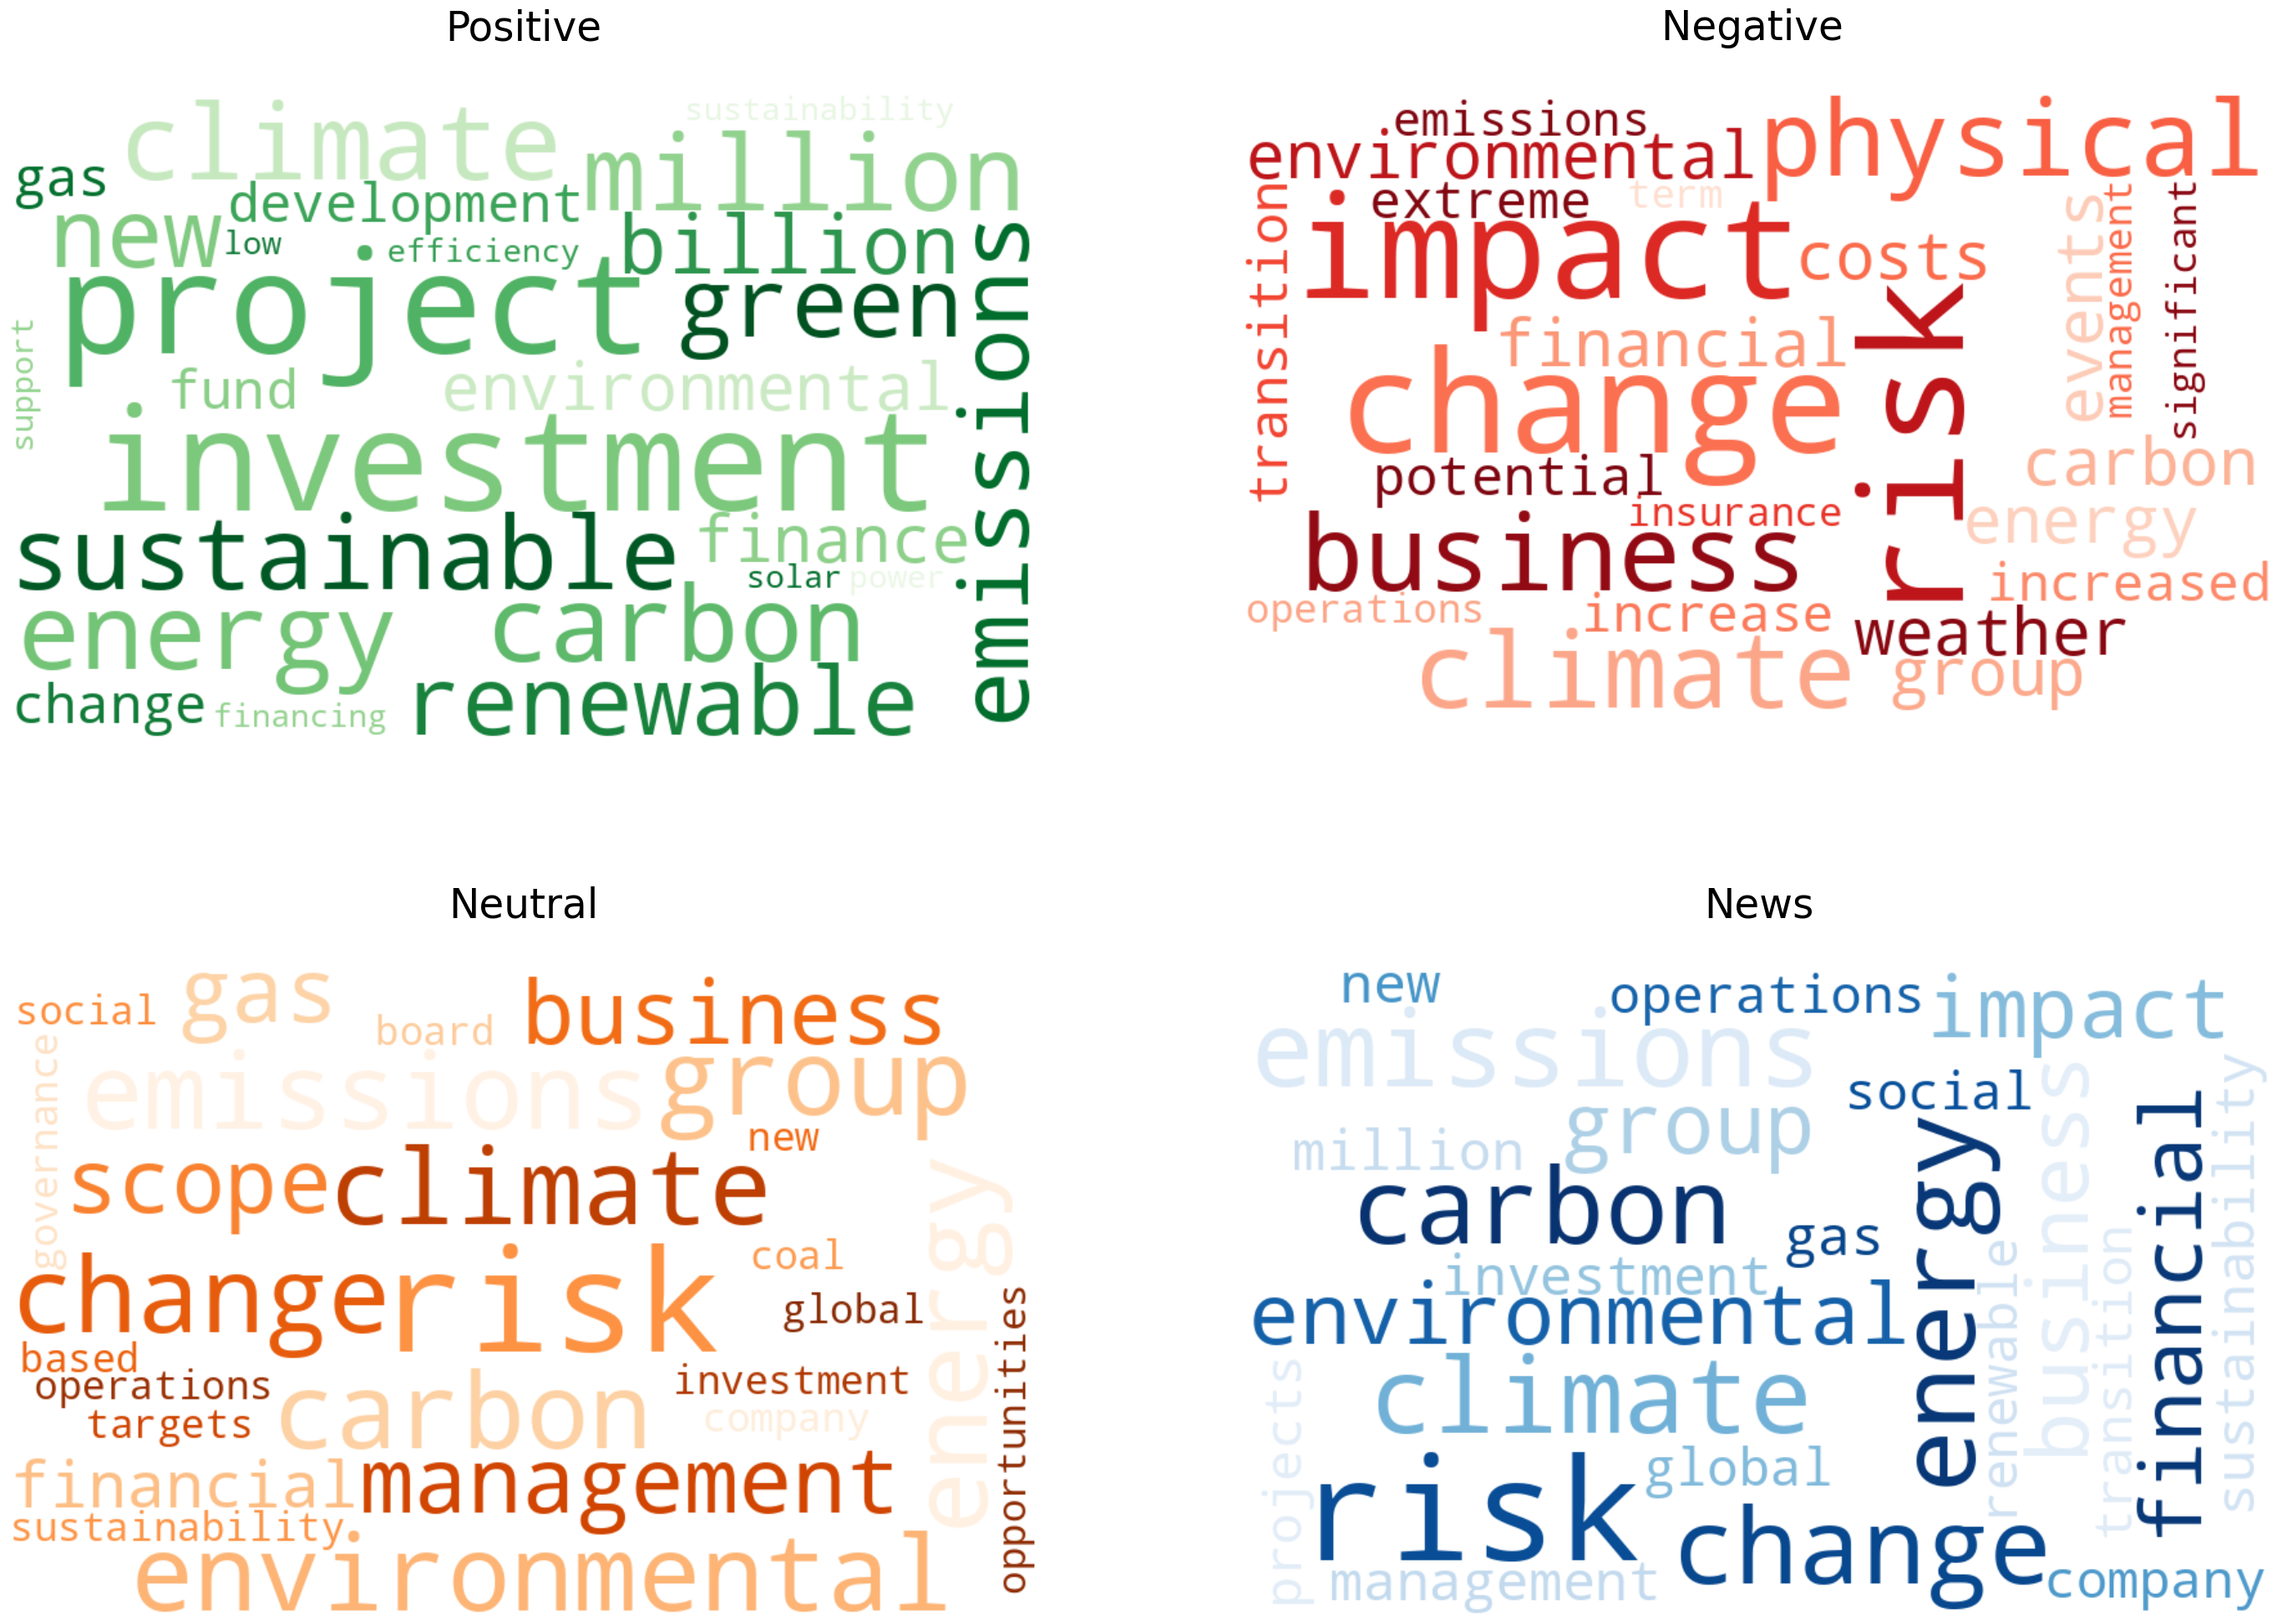

In [ ]:
stopwords = set(STOPWORDS)
stopwords_custom = {"year", "including", "related"}
stopwords.update(stopwords_custom)
# Create wordcloud for the anti climate change class
anti_wordcloud = WordCloud(width=800,
                           height=500,
                           random_state=110,
                           max_font_size=110,
                           background_color='white',
                           stopwords = stopwords,
                           colormap="Reds").generate(anti_words)

# Create wordcolud for the pro climate change class
pro_wordcloud = WordCloud(width=800,
                          height=500,
                          random_state=73,
                          max_font_size=110,
                          background_color='white',
                          stopwords = stopwords,
                          colormap="Greens").generate(pro_words)

# Create wordcolud for the news climate change class
news_wordcloud = WordCloud(width=800,
                          height=500,
                          random_state=0,
                          max_font_size=110,
                          background_color='white',
                          stopwords = stopwords,
                          colormap="Blues").generate(news_words)

# Create wordcolud for the neutral climate change class
neutral_wordcloud = WordCloud(width=800,
                          height=500,
                          random_state=10,
                          max_font_size=110,
                          background_color='white',
                          stopwords = stopwords,
                          colormap="Oranges").generate(neutral_words)


# Plot pro and anti wordclouds next to one another for comparisson
f, axarr = plt.subplots(2,2, figsize=(35,25))
axarr[0,0].imshow(pro_wordcloud, interpolation="bilinear")
axarr[0,1].imshow(anti_wordcloud, interpolation="bilinear")
axarr[1,0].imshow(neutral_wordcloud, interpolation="bilinear")
axarr[1,1].imshow(news_wordcloud, interpolation="bilinear")

# Remove the ticks on the x and y axes
for ax in f.axes:
    plt.sca(ax)
    plt.axis('off')

axarr[0,0].set_title('Positive\n', fontsize=35)
axarr[0,1].set_title('Negative \n', fontsize=35)
axarr[1,0].set_title('Neutral\n', fontsize=35)
axarr[1,1].set_title('News\n', fontsize=35)
#plt.tight_layout()
plt.show()

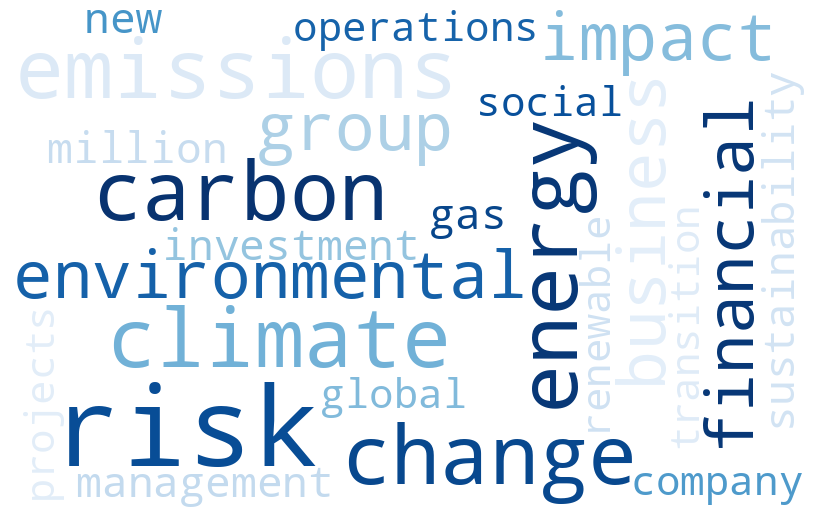

In [ ]:
# Create wordcolud for the news climate change dataframe
news_wordcloud = WordCloud(width=800,
                          height=500,
                          random_state=0,
                          max_font_size=110,
                          background_color='white',
                          stopwords = stopwords,
                          colormap="Blues").generate(news_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(news_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


In [ ]:
import spacy
# Downloads
nlp = spacy.load('en_core_web_sm')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
def entity_extractor(news):

    """
    This function extracts the top 10 people, organizations and geopolitical entities
    in a collection of tweets.
    The information is then saved in a new dataframe

    Input:
    tweet: lemmatized tweets
           datatype: 'str'

    Output:
    df: dataframe containing the top 10 people, organizations and gpe's in a collection of tweets
        datatype: dataframe ('str')
    """

    def get_people(news):
        words = nlp(news)
        people = [w.text for w in words.ents if w.label_== 'PERSON']
        return people

    def get_org(news):
        words = nlp(news)
        org = [w.text for w in words.ents if w.label_== 'ORG']
        return org

    def get_gpe(news):
        words = nlp(news)
        gpe = [w.text for w in words.ents if w.label_== 'GPE']
        return gpe

    # Extract the top 10 people
    people = news.apply(lambda x: get_people(x))
    people = [x for sub in people for x in sub]
    people_counter = Counter(people)
    people_count = people_counter.most_common(10)
    people, people_count = map(list, zip(*people_count))

    # Extract the top 10 organizations
    org = news.apply(lambda x: get_org(x))
    org = [x for sub in org for x in sub]
    org_counter = Counter(org)
    org_count = org_counter.most_common(10)
    org, org_count = map(list, zip(*org_count))

    # Extract the top 10 geopolitical entities
    gpe = news.apply(lambda x: get_gpe(x))
    gpe = [x for sub in gpe for x in sub]
    gpe_counter = Counter(gpe)
    gpe_count = gpe_counter.most_common(10)
    gpe, gpe_count = map(list, zip(*gpe_count))

    # Create a dataframe to store the information
    df = pd.DataFrame({'people' : people})
    df['geopolitics'] = gpe
    df['organizations'] = org

    return df

# Extract top entities for each class
anti_info = entity_extractor(df['message'][df['sentiment']=='Negative'])
pro_info = entity_extractor(df['message'][df['sentiment']=='Positive'])


In [ ]:
print('Entities related to Positive Climate Change News')
display(pro_info.head(9))

In [ ]:
print('Entities related to Negative Climate Change News')
display(anti_info)

Entities related to Negative Climate Change News


,people,geopolitics,organizations
0,Governance,U.S.,Group
1,Maersk,UK,GHG
2,Equinor,Australia,Bank
3,Coles,California,Linde
4,Tier 1,Aegon,TCFD
5,bush,Alberta,ESG
6,Slight,South Africa,Eni
7,Maria,"Environmental, Social",ERM
8,Ping An,India,P&C
9,BNP Paribas,Zurich,NRG


**Model Exploration and Training**

In [ ]:
def train_valid_test_split(inputs, labels, train_fraction=0.8):
    """ Splits a given dataset into three sets; training, validation and test """

    # Separate indices of negative and positive data points
    neg_indices = pd.Series(labels.loc[(labels==0)].index)
    neut_indices = pd.Series(labels.loc[(labels==1)].index)
    pos_indices = pd.Series(labels.loc[(labels==2)].index)

    n_valid = int(min([len(neg_indices), len(neut_indices), len(pos_indices)]) * ((1-train_fraction)/2.0))
    n_test = n_valid

    neg_test_inds = neg_indices.sample(n=n_test, random_state=random_seed)
    neg_valid_inds = neg_indices.loc[~neg_indices.isin(neg_test_inds)].sample(n=n_test, random_state=random_seed)
    neg_train_inds = neg_indices.loc[~neg_indices.isin(neg_test_inds.tolist()+neg_valid_inds.tolist())]

    neut_test_inds = neut_indices.sample(n=n_test, random_state=random_seed)
    neut_valid_inds = neut_indices.loc[~neut_indices.isin(neut_test_inds)].sample(n=n_test, random_state=random_seed)
    neut_train_inds = neut_indices.loc[~neut_indices.isin(neut_test_inds.tolist()+neut_valid_inds.tolist())]

    pos_test_inds = pos_indices.sample(n=n_test, random_state=random_seed)
    pos_valid_inds = pos_indices.loc[~pos_indices.isin(pos_test_inds)].sample(n=n_test, random_state=random_seed)
    pos_train_inds = pos_indices.loc[
        ~pos_indices.isin(pos_test_inds.tolist()+pos_valid_inds.tolist())
    ]

    tr_x = inputs.loc[neg_train_inds.tolist() + neut_train_inds.tolist() + pos_train_inds.tolist()].sample(frac=1.0, random_state=random_seed)
    tr_y = labels.loc[neg_train_inds.tolist() + neut_train_inds.tolist() + pos_train_inds.tolist()].sample(frac=1.0, random_state=random_seed)
    v_x = inputs.loc[neg_valid_inds.tolist() + neut_valid_inds.tolist() + pos_valid_inds.tolist()].sample(frac=1.0, random_state=random_seed)
    v_y = labels.loc[neg_valid_inds.tolist() + neut_valid_inds.tolist() + pos_valid_inds.tolist()].sample(frac=1.0, random_state=random_seed)
    ts_x = inputs.loc[neg_test_inds.tolist() + neut_test_inds.tolist() + pos_test_inds.tolist()].sample(frac=1.0, random_state=random_seed)
    ts_y = labels.loc[neg_test_inds.tolist() + neut_test_inds.tolist() + pos_test_inds.tolist()].sample(frac=1.0, random_state=random_seed)

    # tr_y = pd.get_dummies(tr_y, columns=['label'], prefix='class')
    # v_y = pd.get_dummies(v_y, columns=['label'], prefix='class')
    # ts_y = pd.get_dummies(ts_y, columns=['label'], prefix='class')

    print('Training data: {}'.format(len(tr_x)))
    print('Validation data: {}'.format(len(v_x)))
    print('Test data: {}'.format(len(ts_x)))

    return (tr_x, tr_y), (v_x, v_y), (ts_x, ts_y)

(tr_x, tr_y), (v_x, v_y), (ts_x, ts_y) = train_valid_test_split(inputs, labels)

Training data: 1621
Validation data: 131
Test data: 138


In [ ]:
print("Some sample targets")
print(tr_y.head())
print(tr_x.head())

Some sample targets
795    1
328    2
596    0
200    0
703    1
Name: label, dtype: int64
795    [review, process, review, environmental, mater...
328    [usd, 310, million, green, bond, carry, coupon...
596    [2019, pme, redesign, passively, manage, equit...
200    [addition, many, project, ’, end-customers, la...
703    [believe, important, dedicate, in-, house, esg...
Name: message, dtype: object


In [ ]:

'''
Analysis of vocabulary
'''
from collections import Counter
# Create a large list which contains all the words in all the reviews
data_list = [w for doc in tr_x for w in doc]

# Create a Counter object from that list
# Counter returns a dictionary, where key is a word and the value is the frequency
cnt = Counter(data_list)

# Convert the result to a pd.Series
freq_df = pd.Series(list(cnt.values()), index=list(cnt.keys())).sort_values(ascending=False)
# Print most common words
print(freq_df.head(n=10))

# Print summary statistics
print(freq_df.describe())

risk             1182
climate           955
change            785
emission          708
energy            616
impact            568
’                 545
include           512
business          503
environmental     482
dtype: int64
count    6416.000000
mean       11.895106
std        40.489022
min         1.000000
25%         1.000000
50%         2.000000
75%         7.000000
max      1182.000000
dtype: float64


In [ ]:
'''
Analysing thesequence length (number of words) of tweets
'''
# Create a pd.Series, which contain the sequence length for each review
seq_length_ser = tr_x.str.len()

# Get the median as well as summary statistics of the sequence length
print("\nSome summary statistics")
print("Median length: {}\n".format(seq_length_ser.median()))
seq_length_ser.describe()

print("\nComputing the statistics between the 10% and 90% quantiles (to ignore outliers)")
p_10 = seq_length_ser.quantile(0.1)
p_90 = seq_length_ser.quantile(0.9)

seq_length_ser[(seq_length_ser >= p_10) & (seq_length_ser < p_90)].describe(percentiles=[0.33, 0.66])


Some summary statistics
Median length: 42.0


Computing the statistics between the 10% and 90% quantiles (to ignore outliers)


count    1300.000000
mean       42.986154
std        11.412746
min        25.000000
33%        36.000000
50%        42.000000
66%        47.000000
max        71.000000
Name: message, dtype: float64

In [ ]:
n_vocab = (freq_df >= 10).sum()
print("Using a vocabulary of size: {}".format(n_vocab))

Using a vocabulary of size: 1294


In [ ]:
'''
Transforming text to numbers
'''
from tensorflow.keras.preprocessing.text import Tokenizer

# Define a tokenizer that will convert words to IDs
# words that are less frequent will be replaced by 'unk'
tokenizer = Tokenizer(num_words=n_vocab, oov_token='unk', lower=False)

# Fit the tokenizer on the data
tokenizer.fit_on_texts(tr_x.tolist())

# Convert all of train/validation/test data to sequences of IDs
tr_x = tokenizer.texts_to_sequences(tr_x.tolist())
v_x = tokenizer.texts_to_sequences(v_x.tolist())
ts_x = tokenizer.texts_to_sequences(ts_x.tolist())

In [ ]:
# Checking the attributes of the tokenizer
word = "climate"
wid = tokenizer.word_index[word]
print("The word id for \"{}\" is: {}".format(word, wid))
wid = 4
word = tokenizer.index_word[wid]
print("The word for id {} is: {}".format(wid, word))

The word id for "climate" is: 3
The word for id 4 is: change


In [ ]:
# Convert words to IDs

# Vocabs not used get assigned id of 1 I think, so since they're not being
# used in the training, it doesn't actually matter
test_text = [
    ['environmental', 'management', 'system', 'encompass', 'series', 'metric', 'related', 'greenhouse', 'gas', 'emission', 'capture', 'forest', 'restoration', 'water', 'withdrawal', 'use', 'energy', 'use', 'generation', 'well', 'waste', 'generation', 'disposal'],
    ['target', 'consume', '100', 'renewable', 'electricity', 'july', '2021', 'europe', '2025', 'market'],
    ['january', '2020', 'new', 'estimation', 'method', 'report', 'unaccounted', 'gas', 'uafg', 'emission', 'result', 'natural', 'gas', 'distribution', 'activity', 'introduce', 'australia', 'approach', 'enables', 'site/network', 'specific', 'uafg', 'value', 'use', 'allow', 'us', 'translate', 'network', 'maintenance', 'replacement', 'activity', 'reportable', 'reduction', 'uafg', 'emission'],
    ['future', 'work', 'climate', 'continue', 'high', 'ap2', "'s", 'agenda', 'implementation', 'task', 'force', 'climate-related', 'financial', 'disclosure', 'part', 'fund', "'s", 'on-going', 'work', '2020', 'focus', 'implement', 'new', 'sustainability', 'strategy', 'strong', 'focus', 'climate', 'among', 'thing', 'fund', 'develop', 'internal', 'index', 'sustainability', 'profile', 'ambition', 'comply', 'criterion', 'eu', 'paris', 'align', 'benchmark', 'asset', 'management', 'work', 'actively', 'different', 'way', 'include', 'climate', 'risk', 'opportunity', 'analysis', 'find', 'investment', 'opportunity', 'different', 'asset', 'class', 'integrate', 'climate', 'analysis', 'overall', 'alm', 'analysis', 'continue', 'develo-', 'ped', 'fund', 'also', 'intend', 'develop', 'view', 'significant', 'climate', 'risk', 'opportunity', 'asset', 'classes/sectors/', 'geography', 'time', 'horizon'],
    ['however', 'factor', 'may', 'lead', 'commencement', 'engagement', 'decide', 'particularly', 'focus', 'company', 'relation', 'particular', 'esg-related', 'concern', 'not', 'publish', 'adequate', 'environmental', 'information', '‘', 'laggard', '’', 'regard', 'commitment', 'address', 'climate', 'change', 'issue'],
]

test_seq = tokenizer.texts_to_sequences(test_text)

for text, seq in zip(test_text, test_seq):
    print("Text: {}".format(text))
    print("Sequence: {}".format(seq))
    print("\n")

Text: ['environmental', 'management', 'system', 'encompass', 'series', 'metric', 'related', 'greenhouse', 'gas', 'emission', 'capture', 'forest', 'restoration', 'water', 'withdrawal', 'use', 'energy', 'use', 'generation', 'well', 'waste', 'generation', 'disposal']
Sequence: [11, 23, 99, 1, 782, 254, 158, 126, 24, 5, 1089, 428, 1, 85, 1, 22, 6, 22, 134, 68, 200, 134, 1240]


Text: ['target', 'consume', '100', 'renewable', 'electricity', 'july', '2021', 'europe', '2025', 'market']
Sequence: [30, 848, 303, 44, 67, 857, 382, 846, 452, 82]


Text: ['january', '2020', 'new', 'estimation', 'method', 'report', 'unaccounted', 'gas', 'uafg', 'emission', 'result', 'natural', 'gas', 'distribution', 'activity', 'introduce', 'australia', 'approach', 'enables', 'site/network', 'specific', 'uafg', 'value', 'use', 'allow', 'us', 'translate', 'network', 'maintenance', 'replacement', 'activity', 'reportable', 'reduction', 'uafg', 'emission']
Sequence: [727, 63, 31, 1, 695, 36, 1, 24, 1, 5, 32, 75, 24, 27

In [ ]:
def get_tf_pipeline(text_seq, labels, batch_size=64, bucket_boundaries=[5,15], max_length=50, shuffle=False):
    """ Define a data pipeline that converts sequences to batches of data """

    num_classes = 3
    # Concatenate the label and the input sequence so that we don't mess up the order when we shuffle
    data_seq = [[b] + a for a, b in zip(text_seq, labels)]
    # Define the variable sequence dataset as a ragged tensor
    tf_data = tf.ragged.constant(data_seq)[:, :max_length]

    # One-hot encode labels
    labels = tf.one_hot(labels, depth=num_classes, dtype=tf.int32)

    # Create a dataset out of the ragged tensor
    text_ds = tf.data.Dataset.from_tensor_slices((tf_data, labels))
    text_ds = text_ds.filter(lambda x, y: tf.size(x) > 1)

    # Bucketing the data
    # Bucketing assigns each sequence to a bucket depending on the length
    # If you define bucket boundaries as [5, 15], then you get buckets,
    # [0, 5], [5, 15], [15,inf]
    bucket_fn = tf.data.experimental.bucket_by_sequence_length(
        lambda x, y: tf.cast(tf.shape(x)[0], 'int32'),
        bucket_boundaries=bucket_boundaries,
        bucket_batch_sizes=[batch_size, batch_size, batch_size],
        padded_shapes=(tf.TensorShape([max_length]), tf.TensorShape([num_classes])),
        padding_values=(0, 0),
        pad_to_bucket_boundary=False
    )

    # Apply bucketing
    text_ds = text_ds.map(lambda x, y: (x, y)).apply(bucket_fn)

    # Shuffle the data
    if shuffle:
        text_ds = text_ds.shuffle(buffer_size=10 * batch_size)

    return text_ds

In [ ]:
'''Testing the bucketing function '''
train_ds = get_tf_pipeline(tr_x, tr_y, shuffle=True)
valid_ds = get_tf_pipeline(v_x, v_y)

print("Some training data ...")
for x,y in train_ds.take(2):
    print("Input sequence shape: {}".format(x.shape))
    print(y)

print("\nSome validation data ...")
for x,y in valid_ds.take(2):
    print("Input sequence shape: {}".format(x.shape))
    print(y)

In [ ]:
import tensorflow.keras.backend as K
from keras.losses import categorical_crossentropy

K.clear_session()

class OnehotEncoder(tf.keras.layers.Layer):
    def __init__(self, depth, **kwargs):
        super(OnehotEncoder, self).__init__(**kwargs)
        self.depth = depth

    def build(self, input_shape):
        pass

    def call(self, inputs):

        inputs = tf.cast(inputs, 'int32')

        if len(inputs.shape) == 3:
            inputs = inputs[:,:,0]
        return tf.one_hot(inputs, depth=self.depth)


    def compute_mask(self, inputs, mask=None):
        return mask

    def get_config(self):
        config = super().get_config().copy()
        config.update({'depth': self.depth})
        return config

# You will see the following error if you don't filter out all zero (empty) records from the dataset
# these records return a vector of all zeros which leads the LSTM layer to error out
# CUDNN_STATUS_BAD_PARAM
# in tensorflow/stream_executor/cuda/cuda_dnn.cc(1496):
# 'cudnnSetRNNDataDescriptor(
#     data_desc.get(), data_type,
#     layout,
#     max_seq_length, batch_size, data_size, seq_lengths_array, (void*)&padding_fill
# )'

# Code listing 9.5

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=(None,)),
    # Create a mask to mask out zero inputs
    tf.keras.layers.Masking(mask_value=0),
    # After creating the mask, convert inputs to onehot encoded inputs
    OnehotEncoder(depth=n_vocab),
    # Defining an LSTM layer
    tf.keras.layers.LSTM(128, return_state=False, return_sequences=False),
    # tf.keras.layers.Flatten(),
    # Defining a Dense layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 masking (Masking)           (None, None, 1)           0         
                                                                 
 onehot_encoder (OnehotEnco  (None, None, 1294)        0         
 der)                                                            
                                                                 
 lstm (LSTM)                 (None, 128)               728576    
                                                                 
 dense (Dense)               (None, 512)               66048     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [ ]:
'''Checking the mask '''
inp = tf.expand_dims(tf.constant([[2,3,4,0,0], [2,4,6,12,0]], dtype='int32'),axis=-1)
# Create a mask to mask out zero inputs
mask_out = tf.keras.layers.Masking(mask_value=0)(inp)
print("Masking layer's mask")
print(mask_out._keras_mask)
# After creating the mask, convert inputs to onehot encoded inputs
onehot_out = OnehotEncoder(depth=10)(mask_out)
print("Onehot encoder layer's mask")
print(onehot_out._keras_mask)
# Defining an LSTM layer
lstm_out = tf.keras.layers.LSTM(24, return_state=False, return_sequences=False)(
    onehot_out, mask=onehot_out._keras_mask
)

Masking layer's mask
tf.Tensor(
[[ True  True  True False False]
 [ True  True  True  True False]], shape=(2, 5), dtype=bool)
Onehot encoder layer's mask
tf.Tensor(
[[ True  True  True False False]
 [ True  True  True  True False]], shape=(2, 5), dtype=bool)


In [ ]:
print("Defining data pipelines")

# Using a batch size of 128
batch_size = 128
train_ds = get_tf_pipeline(tr_x, tr_y, batch_size=batch_size, shuffle=True)
valid_ds = get_tf_pipeline(v_x, v_y, batch_size=batch_size)
test_ds = get_tf_pipeline(ts_x, ts_y, batch_size=batch_size)
print('\tDone...')

Defining data pipelines
	Done...


In [ ]:
# There is a class imbalance in the data therefore we are defining a weight for negative inputs
# neg_weight = (tr_y==1).sum()/(tr_y==0).sum()
# print("Will be using a weight of {} for negative samples".format(neg_weight))

from sklearn.utils.class_weight import compute_class_weight

# Assuming you have three classes: 0, 1, and 2
classes = [0,1,2]

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=tr_y)
class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}
print("Class Weights:", class_weight_dict)


Class Weights: {0: 0.9035674470457079, 1: 0.8052657724788872, 2: 1.535037878787879}


In [ ]:
# Section 9.5

os.makedirs('eval', exist_ok=True)

# Logging the performance metrics to a CSV file
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join('eval','1_sentiment_analysis.log'))

monitor_metric = 'val_loss'
mode = 'min'
print("Using metric={} and mode={} for EarlyStopping".format(monitor_metric, mode))

# Reduce LR callback
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor=monitor_metric, factor=0.1, patience=3, mode=mode, min_lr=1e-8
)

# EarlyStopping itself increases the memory requirement
# restore_best_weights will increase the memory req for large models
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor=monitor_metric, patience=6, mode=mode, restore_best_weights=False
)

# Train the model
t1 = time.time()
model.fit(train_ds, validation_data=valid_ds, epochs=10, class_weight=class_weight_dict, callbacks=[es_callback, lr_callback, csv_logger])
t2 = time.time()

print("It took {} seconds to complete the training".format(t2-t1))

Using metric=val_loss and mode=min for EarlyStopping
Epoch 1/10
14/14 [==============================] - 15s 695ms/step - loss: 1.0882 - accuracy: 0.5139 - val_loss: 1.0572 - val_accuracy: 0.5878 - lr: 0.0010
Epoch 2/10
14/14 [==============================] - 8s 569ms/step - loss: 0.8812 - accuracy: 0.6804 - val_loss: 0.8325 - val_accuracy: 0.6412 - lr: 0.0010
Epoch 3/10
14/14 [==============================] - 8s 566ms/step - loss: 0.5806 - accuracy: 0.7884 - val_loss: 0.5235 - val_accuracy: 0.8092 - lr: 0.0010
Epoch 4/10
14/14 [==============================] - 11s 745ms/step - loss: 0.3665 - accuracy: 0.8890 - val_loss: 0.4250 - val_accuracy: 0.8168 - lr: 0.0010
Epoch 5/10
14/14 [==============================] - 6s 453ms/step - loss: 0.2071 - accuracy: 0.9426 - val_loss: 0.6095 - val_accuracy: 0.8092 - lr: 0.0010
Epoch 6/10
14/14 [==============================] - 8s 498ms/step - loss: 0.2076 - accuracy: 0.9426 - val_loss: 0.3262 - val_accuracy: 0.8855 - lr: 0.0010
Epoch 7/10
14/1

In [ ]:
os.makedirs('models', exist_ok=True)
tf.keras.models.save_model(model, os.path.join('models', 'lstm.h5'))

<ipython-input-32-e81cf6b3c308>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, os.path.join('models', 'lstm.h5'))


In [ ]:
model.evaluate(test_ds)

2/2 [==============================] - 1s 95ms/step - loss: 0.2753 - accuracy: 0.9275


[0.27528175711631775, 0.9275362491607666]

In [ ]:
temp = test_ds.take(1)
# for x,y in temp:
#   print(tf.expand_dims(x[0], axis=0))
#   print(y[0])
input = [[1, 95, 1258, 219, 1, 1, 3, 4, 118, 1, 439, 66, 232, 95, 687, 439, 39,
          61, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
predicted = model.predict(input)[0]
predicted_class = int(tf.argmax(predicted).numpy())
if predicted_class == 0:
  print("The sentiment is negative (0)")

elif predicted_class == 1:
  print("The sentiment is neutral (1)")

elif predicted_class == 2:
  print("The sentiment is positive (2)")


1/1 [==============================] - 0s 98ms/step
The sentiment is neutral


In [ ]:
# Section 9.6

import tensorflow.keras.backend as K

K.clear_session()

# Code listing 9.7
model = tf.keras.models.Sequential([

    # Adding an Embedding layer
    # You will see the following error if you don't filter out all zero (empty) records from the dataset
    # these records return a vector of all zeros which leads the LSTM layer to error out
    # CUDNN_STATUS_BAD_PARAM
    # in tensorflow/stream_executor/cuda/cuda_dnn.cc(1496):
    # 'cudnnSetRNNDataDescriptor(
    #     data_desc.get(), data_type,
    #     layout,
    #     max_seq_length, batch_size, data_size, seq_lengths_array, (void*)&padding_fill
    # )'
    tf.keras.layers.Embedding(input_dim=n_vocab+1, output_dim=128, mask_zero=True, input_shape=(None,)),
    # Defining an LSTM layer
    tf.keras.layers.LSTM(128, return_state=False, return_sequences=False),
    # Defining Dense layers
    tf.keras.layers.Dense(512, activation='relu'),
    # Defining a dropout layer
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         165760    
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 512)               66048     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 364931 (1.39 MB)
Trainable params: 364931 (1.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Section 9.7

print("Defining data pipelines")
batch_size = 128
train_ds = get_tf_pipeline(tr_x, tr_y, batch_size=batch_size, shuffle=True)
valid_ds = get_tf_pipeline(v_x, v_y, batch_size=batch_size,)
test_ds = get_tf_pipeline(ts_x, ts_y, batch_size=batch_size)
print('\tDone...')

os.makedirs('eval', exist_ok=True)

# Logging the performance metrics to a CSV file
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join('eval','2_sentiment_analysis_embeddings.log'))

monitor_metric = 'val_loss'
mode = 'min' if 'loss' in monitor_metric else 'max'
print("Using metric={} and mode={} for EarlyStopping".format(monitor_metric, mode))

# Reduce LR callback
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor=monitor_metric, factor=0.1, patience=3, mode=mode, min_lr=1e-8
)

# EarlyStopping itself increases the memory requirement
# restore_best_weights will increase the memory req for large models
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor=monitor_metric, patience=6, mode=mode, restore_best_weights=False
)

t1 = time.time()

model.fit(train_ds, validation_data=valid_ds, epochs=10, class_weight=class_weight_dict, callbacks=[es_callback, lr_callback, csv_logger])
t2 = time.time()

print("It took {} seconds to complete the training".format(t2-t1))

Defining data pipelines
	Done...
Using metric=val_loss and mode=min for EarlyStopping
Epoch 1/10
14/14 [==============================] - 10s 399ms/step - loss: 1.0827 - accuracy: 0.3819 - val_loss: 1.0133 - val_accuracy: 0.4809 - lr: 0.0010
Epoch 2/10
14/14 [==============================] - 3s 175ms/step - loss: 0.8000 - accuracy: 0.5830 - val_loss: 0.7747 - val_accuracy: 0.5725 - lr: 0.0010
Epoch 3/10
14/14 [==============================] - 3s 177ms/step - loss: 0.6039 - accuracy: 0.5916 - val_loss: 0.6838 - val_accuracy: 0.6107 - lr: 0.0010
Epoch 4/10
14/14 [==============================] - 4s 251ms/step - loss: 0.4737 - accuracy: 0.7156 - val_loss: 0.5968 - val_accuracy: 0.7252 - lr: 0.0010
Epoch 5/10
14/14 [==============================] - 3s 174ms/step - loss: 0.3025 - accuracy: 0.8945 - val_loss: 0.5419 - val_accuracy: 0.8015 - lr: 0.0010
Epoch 6/10
14/14 [==============================] - 3s 190ms/step - loss: 0.1967 - accuracy: 0.9365 - val_loss: 0.5975 - val_accuracy: 0.7

In [ ]:
os.makedirs('models', exist_ok=True)
tf.keras.models.save_model(model, os.path.join('models', 'LSTM_embedding.h5'))

<ipython-input-29-a919478f9018>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, os.path.join('models', 'LSTM_embedding.h5'))


In [ ]:
test_ds = get_tf_pipeline(ts_x, ts_y, batch_size=128)
model.evaluate(test_ds)

2/2 [==============================] - 0s 84ms/step - loss: 0.4482 - accuracy: 0.8913


[0.44823265075683594, 0.8913043737411499]

In [ ]:
temp = test_ds.take(1)
# for x,y in temp:
#   print(tf.expand_dims(x[0], axis=0))
#   print(y[0])
input = [[1, 95, 1258, 219, 1, 1, 3, 4, 118, 1, 439, 66, 232, 95, 687, 439, 39,
          61, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
predicted = model.predict(input)[0]
print("class: ", int(tf.argmax(predicted).numpy()))

1/1 [==============================] - 0s 64ms/step
class:  1


In [ ]:
! pip install gradio

In [57]:
import gradio as gr
import torch
import json
import random


def analyze(article_text):
    cleaned = clean_text(article_text)
    # print(cleaned)
    cleaned_tokens = tokenizer.texts_to_sequences([cleaned])
    # print(cleaned_tokens)
    test_data = get_tf_pipeline(cleaned_tokens, [1], batch_size=1)
    predicted = model.predict(x)[0]
    predicted_class = int(tf.argmax(predicted).numpy())
    if predicted_class == 0:
      random_choice = "Negative"
    elif predicted_class == 1:
      random_choice = "Neutral"
    elif predicted_class == 2:
      random_choice = "Positive"
    # random_choice = predicted_class
    random_percentage = tf.argmax(predicted)*100
    formatted_percentage = f'{random_percentage:.2f}%'
    return cleaned, random_choice, formatted_percentage


with gr.Blocks() as demo:
    input1 = gr.Textbox(label="Copy and paste your article's text here", lines=5)
    output = gr.Textbox(label="This is the article text we analyzed")
    output_sentiment = gr.Textbox(label="sentiment")
    output_probability = gr.Textbox(label="probability")
    analyze_btn = gr.Button("Analyze")
    analyze_btn.click(fn=analyze, inputs=input1, outputs=[output, output_sentiment, output_probability], api_name="analyze")

demo.launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [ ]:
test_ds = get_tf_pipeline(ts_x, ts_y, batch_size=128)

# Go through the test data and gather all examples
test_x = []
test_pred = []
test_y = []
for x, y in test_ds:
    test_x.append(x)
    test_pred.append(model.predict(x, verbose=0))
    test_y.append(y)

# Check the sizes
test_x = [doc for t in test_x for doc in t.numpy().tolist()]
print("X: {}".format(len(test_x)))
test_pred = tf.concat(test_pred, axis=0).numpy()
print("Pred: {}".format(test_pred.shape))
test_y = tf.concat(test_y, axis=0).numpy()
print("Y: {}".format(test_y.shape))

X: 98
Pred: (98, 1)
Y: (98,)


In [ ]:
sorted_pred = np.argsort(test_pred.flatten())
min_pred = sorted_pred[:5]
max_pred = sorted_pred[-5:]

print("Most negative reviews\n")
print("="*50)
for i in min_pred:
    print(" ".join(tokenizer.sequences_to_texts([test_x[i]])), '\n')

print("\nMost positive reviews\n")
print("="*50)
for i in max_pred:
    print(" ".join(tokenizer.sequences_to_texts([test_x[i]])), '\n')

Most negative reviews

climate change may adverse effect business customer external supplier may adversely affect physical risk climate change include increase temperature sea level frequency severity adverse climatic event include fire storm flood drought effect whether acute chronic nature may directly impact us customer reputational damage environmental factor insurance risk business disruption 

climate change challenge face entire p c insurance industry particular home insurance business affect due change climate pattern increase number cost claim associate severe storm water damage make half home insurance claim unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk 

low carbon fuel standard exist propose environmental legislation regulation develop certain u.s. state canadian unk canadian federal government member european unk regulate carbon fuel standard could result increased cost reduce revenue potential regulation may negatively affect marketing unk ’ unk unk 